In [1]:
%load_ext autoreload
%autoreload 2

## Logistic Regression
<center><img src="../../img/regression_logistic.png" width="700"></center>

In [2]:
import sys
import shap
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

sys.path.append('..')
from utils.preprocessing import load_dataframes

from constants import CATEGORIES

/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
(df_train, df_val, df_test) = load_dataframes()

### Tokenizer

In [11]:
import tiktoken
from nltk.tokenize import word_tokenize
enc = tiktoken.encoding_for_model("gpt-4")

# Binary Classification

## TF-IDF

### Word Tokenizer

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')

X_train = vectorizer.fit_transform(df_train['comment_text'])
X_valid = vectorizer.transform(df_val['comment_text'])
X_test = vectorizer.transform(df_test['comment_text'])

y_train = df_train['overall_toxic']
y_valid = df_val['overall_toxic']
y_test = df_test['overall_toxic']

### Tiktoken

In [ ]:
vectorizer_tt = TfidfVectorizer(stop_words='english', tokenizer=enc)

X_train_tt = vectorizer.fit_transform(df_train['comment_text'])
X_valid_tt = vectorizer.transform(df_val['comment_text'])
X_test_tt = vectorizer.transform(df_test['comment_text'])

y_trai_tt = df_train['overall_toxic']
y_valid_tt = df_val['overall_toxic']
y_test_tt = df_test['overall_toxic']

/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Word Tokenizer Result

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
print(model.score(X_valid, y_valid))
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=['non-toxic', 'toxic']))

0.9553501488328372
              precision    recall  f1-score   support

   non-toxic       0.96      0.99      0.98     28671
       toxic       0.93      0.61      0.73      3244

    accuracy                           0.96     31915
   macro avg       0.94      0.80      0.85     31915
weighted avg       0.95      0.96      0.95     31915



### TikToken Result

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tt, y_trai_tt)
print(model.score(X_valid_tt, y_valid_tt))
y_pred_wt = model.predict(X_valid_tt)
print(classification_report(y_valid_tt, y_pred_wt, target_names=['non-toxic', 'toxic']))

0.9556634811217296
              precision    recall  f1-score   support

   non-toxic       0.96      0.99      0.98     28671
       toxic       0.92      0.62      0.74      3244

    accuracy                           0.96     31915
   macro avg       0.94      0.80      0.86     31915
weighted avg       0.95      0.96      0.95     31915



Target classes (toxic/non-toxic) are not uniformed distributed so class_weight must be set to balanced

In [ ]:
model = LogisticRegression(max_iter=1000,class_weight="balanced")
model.fit(X_train, y_train)
print(model.score(X_valid, y_valid))
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=['non-toxic', 'toxic']))

0.9408428638571205
              precision    recall  f1-score   support

   non-toxic       0.99      0.95      0.97     28671
       toxic       0.66      0.87      0.75      3244

    accuracy                           0.94     31915
   macro avg       0.82      0.91      0.86     31915
weighted avg       0.95      0.94      0.94     31915



In [ ]:
model = LogisticRegression(max_iter=1000,class_weight="balanced")
model.fit(X_train_tt, y_trai_tt)
print(model.score(X_valid_tt, y_valid_tt))
y_pred_wt = model.predict(X_valid_tt)
print(classification_report(y_valid_tt, y_pred_wt, target_names=['non-toxic', 'toxic']))

0.9408428638571205
              precision    recall  f1-score   support

   non-toxic       0.99      0.95      0.97     28671
       toxic       0.66      0.87      0.75      3244

    accuracy                           0.94     31915
   macro avg       0.82      0.91      0.86     31915
weighted avg       0.95      0.94      0.94     31915



Exactly the same result with 2 tokenizer. In our context, recall is privileged. For an average equal accuracy, we achieve a 13% increase in recall with balanced weight, making it a valuable tool in our model's performance.

### Optuna – Search Best Hyperparameters

In [ ]:
import optuna
import numpy as np
from sklearn.metrics import recall_score, f1_score
from typing import Literal
from functools import partial

In [ ]:
def objective(metric: Literal["recall_score", "f1_score"], trial):
    # Load data
    # Suggest values for the hyperparameters

    penalty = trial.suggest_categorical("penalty", ["l1", "l2", None])
    C = trial.suggest_float("C", 0.1, 10, log=True)

    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver="liblinear" if penalty == "l1" else "lbfgs",
        max_iter=1000,
        class_weight="balanced",
    )

    # Train and evaluate the model
    model.fit(X_train, y_train)
    pred_y = model.predict(X_valid)
    score = 0
    if metric == "recall_score":
        score = recall_score(y_valid, pred_y, average="macro")
    if metric == "f1_score":
        score = f1_score(y_valid, pred_y, average="macro")
    return score

In [ ]:
objective_recall = partial(objective, "recall_score")
objective_f1_score = partial(objective, "f1_score")

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_recall, n_trials=25)  # Adjust the number of trials

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-05-10 02:03:14,903] A new study created in memory with name: no-name-bcc7c42a-3a44-4086-a983-9d21c0e25cec
[I 2024-05-10 02:03:17,058] Trial 0 finished with value: 0.8926696327970267 and parameters: {'penalty': 'l1', 'C': 0.11002358216487994}. Best is trial 0 with value: 0.8926696327970267.
[I 2024-05-10 02:03:19,041] Trial 1 finished with value: 0.8908843862861724 and parameters: {'penalty': 'l2', 'C': 0.11763487805444078}. Best is trial 0 with value: 0.8926696327970267.
[I 2024-05-10 02:03:26,842] Trial 2 finished with value: 0.9115962444555201 and parameters: {'penalty': 'l1', 'C': 2.2680961025658024}. Best is trial 2 with value: 0.9115962444555201.
[I 2024-05-10 02:03:31,565] Trial 3 finished with value: 0.9098305444981699 and parameters: {'penalty': 'l2', 'C': 5.672798600340061}. Best is trial 2 with value: 0.9115962444555201.
[I 2024-05-10 02:03:39,171] Trial 4 finished with value: 0.9080276491052602 and parameters: {'penalty': 'l1', 'C': 2.701801150899356}. Best is trial 

Best trial:
  Value: 0.9123443194425503
  Params: 
    penalty: l2
    C: 2.2330147859906573


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_f1_score, n_trials=25)  # Adjust the number of trials

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-05-10 02:17:44,958] A new study created in memory with name: no-name-e6c43d6d-b024-49ba-a01d-c00d40489b91
[I 2024-05-10 02:17:48,425] Trial 0 finished with value: 0.8589827835111878 and parameters: {'penalty': 'l2', 'C': 1.2213498397421092}. Best is trial 0 with value: 0.8589827835111878.
[I 2024-05-10 02:17:58,272] Trial 1 finished with value: 0.8702756781075409 and parameters: {'penalty': 'l1', 'C': 4.579044911775209}. Best is trial 1 with value: 0.8702756781075409.
[I 2024-05-10 02:18:05,098] Trial 2 finished with value: 0.8693922349867571 and parameters: {'penalty': 'l1', 'C': 2.299084191940376}. Best is trial 1 with value: 0.8702756781075409.
[I 2024-05-10 02:18:09,975] Trial 3 finished with value: 0.8635920843801255 and parameters: {'penalty': 'l1', 'C': 1.0977683217949024}. Best is trial 1 with value: 0.8702756781075409.
[I 2024-05-10 02:18:18,343] Trial 4 finished with value: 0.8698484091945009 and parameters: {'penalty': 'l1', 'C': 3.211990429414739}. Best is trial 1 w

Best trial:
  Value: 0.8739696580737106
  Params: 
    penalty: None
    C: 2.1445025462031055


#### Best Model on Macro Recall
    penalty: l2
    C: 2.2330147859906573

In [ ]:
best_model = LogisticRegression(max_iter=1000,class_weight="balanced", penalty='l2', C=2.2330, solver="lbfgs")
best_model.fit(X_train, y_train)
print(best_model.score(X_valid, y_valid))
y_pred = best_model.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=['non-toxic', 'toxic']))

0.946733510888297
              precision    recall  f1-score   support

   non-toxic       0.98      0.96      0.97     28671
       toxic       0.69      0.85      0.76      3244

    accuracy                           0.95     31915
   macro avg       0.84      0.90      0.87     31915
weighted avg       0.95      0.95      0.95     31915



#### Best Model on Macro F1
    penalty: None

In [ ]:
best_model_f1 = LogisticRegression(max_iter=1000,class_weight="balanced", penalty=None, solver="lbfgs")
best_model_f1.fit(X_train, y_train)
print(best_model_f1.score(X_valid, y_valid))
y_pred = best_model_f1.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=['non-toxic', 'toxic']))

0.9519661601127997
              precision    recall  f1-score   support

   non-toxic       0.97      0.97      0.97     28671
       toxic       0.76      0.76      0.76      3244

    accuracy                           0.95     31915
   macro avg       0.87      0.87      0.87     31915
weighted avg       0.95      0.95      0.95     31915



#### Let's try with the model on the test set

In [ ]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['non-toxic', 'toxic']))

              precision    recall  f1-score   support

   non-toxic       0.99      0.88      0.93     57735
       toxic       0.44      0.91      0.60      6243

    accuracy                           0.88     63978
   macro avg       0.72      0.89      0.76     63978
weighted avg       0.94      0.88      0.90     63978



In [ ]:
y_pred = best_model_f1.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['non-toxic', 'toxic']))

              precision    recall  f1-score   support

   non-toxic       0.98      0.91      0.94     57735
       toxic       0.50      0.84      0.63      6243

    accuracy                           0.90     63978
   macro avg       0.74      0.88      0.79     63978
weighted avg       0.93      0.90      0.91     63978



In [ ]:
best_model.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': None,
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Shap Value

In [ ]:
import pandas as pd

In [ ]:
import shap
masker = shap.maskers.Independent(data=X_train)
explainer = shap.LinearExplainer(best_model, masker)

In [ ]:
# Convert csr_matrix to pandas DataFrame
X_train_df = pd.DataFrame(X_train.toarray())

# Select a random subset of your data
subset = X_train_df.sample(n=1000, random_state=0)

In [ ]:
shap_values = explainer.shap_values(subset)

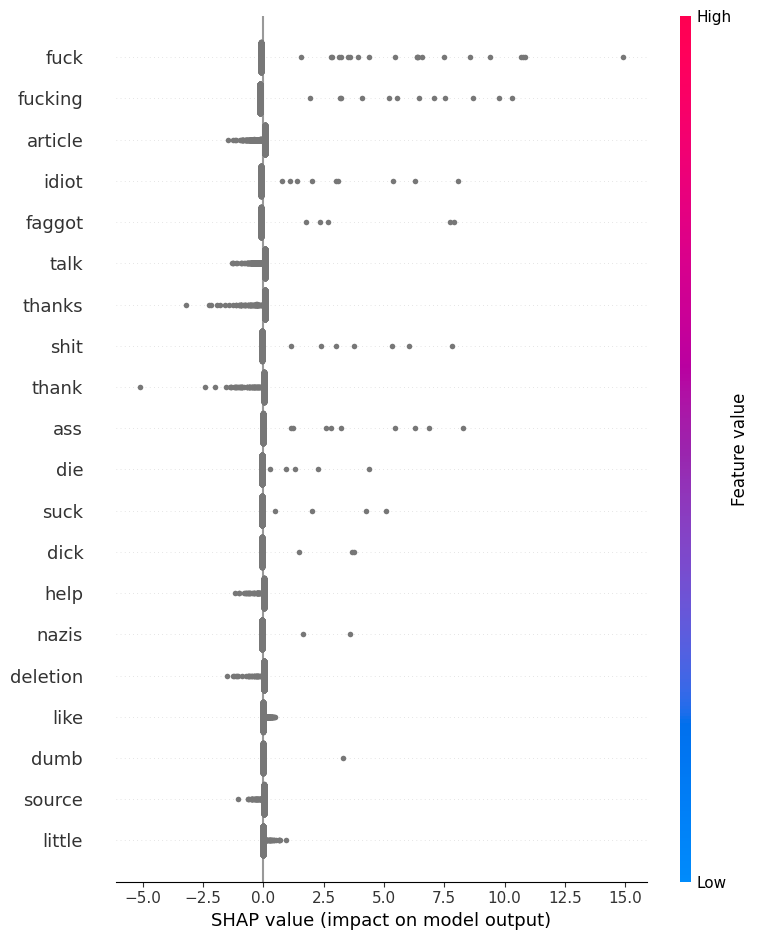

In [ ]:
shap.summary_plot(shap_values, X_train, feature_names=vectorizer.get_feature_names_out(), max_display=20)

## Word to Vec

In [ ]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import os
import gensim.downloader

In [41]:
def vectorize_from_pretrained(model_vector: KeyedVectors, x: np.ndarray, y: np.ndarray):
    means = []
    y_range = []
    for i, doc in enumerate(x):
        mean = np.mean([model_vector[word] for word in doc if word in model_vector], axis=0)
        if not(isinstance(mean, np.ndarray) and len(mean) > 0):
            continue
        y_range.append(i)
        means.append(mean)
    return np.vstack(means), y[y_range]

In [42]:
def vectorize_from_scratch(model_vector, x: np.ndarray, y:np.ndarray):
    means = []
    y_range = []
    for i, doc in enumerate(x):
        mean = np.mean([model_vector.wv[word] for word in doc if word in model_vector.wv], axis=0)
        if not(isinstance(mean, np.ndarray) and len(mean) > 0):
            continue
        y_range.append(i)
        means.append(mean)
    return np.vstack(means), y[y_range]

Load word tokenized data

In [49]:
dfs = [df_train, df_val, df_test]
x_token_paths = ["data/x_train_tokens.npy", "data/x_valid_tokens.npy", "data/x_test_tokens.npy"]
x_tokens = []

for df, x_token_path in zip(dfs, x_token_paths):
    if os.path.exists(x_token_path): 
        x_token = np.load(x_token_path, allow_pickle=True)
    else:
        x_token = df.apply(lambda row: word_tokenize(row['comment_text']), axis=1).to_numpy()
        np.save(x_token_path, x_token)
    x_tokens.append(x_token) 

x_train_tokens, x_valid_tokens, x_test_tokens = x_tokens

In [30]:
y_train = df_train['overall_toxic'].to_numpy()
y_valid = df_val['overall_toxic'].to_numpy()
y_test = df_test['overall_toxic'].to_numpy()

### PreTrained

In [58]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [59]:
glove_vectors = gensim.downloader.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [60]:
# X_train_w2v,y_train_w2v = vectorize_from_pretrained(glove_vectors, x_train_tokens, y_train) 
# X_valid_w2v ,y_valid_w2v= vectorize_from_pretrained(glove_vectors,x_valid_tokens, y_valid) 
# X_test_w2v, y_test_w2v = vectorize_from_pretrained(glove_vectors,x_test_tokens, y_test)
# np.save("data/X_train_w2v", X_train_w2v)
# np.save("data/y_train_w2v", y_train_w2v)
# np.save("data/X_valid_w2v", X_valid_w2v)
# np.save("data/y_valid_w2v", y_valid_w2v)
# np.save("data/X_test_w2v", X_test_w2v)
# np.save("data/y_test_w2v", y_test_w2v)

/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [61]:
X_train_w2v,y_train_w2v = np.load("data/X_train_w2v.npy"), np.load("data/y_train_w2v.npy") 
X_valid_w2v ,y_valid_w2v= np.load("data/X_valid_w2v.npy"), np.load("data/y_valid_w2v.npy")
X_test_w2v, y_test_w2v = np.load("data/X_test_w2v.npy"), np.load("data/y_test_w2v.npy")

In [78]:
model_w2 = LogisticRegression(max_iter=1000, class_weight="balanced")
model_w2.fit(X_train_w2v, y_train_w2v)
print(classification_report(y_valid_w2v, model_w2.predict(X_valid_w2v)))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     28669
           1       0.42      0.83      0.56      3243

    accuracy                           0.86     31912
   macro avg       0.70      0.85      0.74     31912
weighted avg       0.92      0.86      0.88     31912



### Scratch Word2Vec Model

In [67]:
# model_vector = Word2Vec(sentences=x_train_tokens, min_count=1, window=10, workers=8, vector_size=50)
# model_vector.save("data/word2vec_scratch.model")

In [71]:
model_vector = Word2Vec.load("data/word2vec_scratch.model")

In [72]:
X_train_w2v,y_train_w2v = vectorize_from_scratch(model_vector, x_train_tokens, y_train) 
X_valid_w2v ,y_valid_w2v= vectorize_from_scratch(model_vector,x_valid_tokens, y_valid) 
X_test_w2v, y_test_w2v = vectorize_from_scratch(model_vector,x_test_tokens, y_test)
np.save("data/X_train_w2v_scratch", X_train_w2v)
np.save("data/y_train_w2v_scratch", y_train_w2v)
np.save("data/X_valid_w2v_scratch", X_valid_w2v)
np.save("data/y_valid_w2v_scratch", y_valid_w2v)
np.save("data/X_test_w2v_scratch", X_test_w2v)
np.save("data/y_test_w2v_scratch", y_test_w2v)

/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [73]:
X_train_w2v,y_train_w2v = np.load("data/X_train_w2v_scratch.npy"), np.load("data/y_train_w2v_scratch.npy") 
X_valid_w2v ,y_valid_w2v= np.load("data/X_valid_w2v_scratch.npy"), np.load("data/y_valid_w2v_scratch.npy")
X_test_w2v, y_test_w2v = np.load("data/X_test_w2v_scratch.npy"), np.load("data/y_test_w2v_scratch.npy")

In [77]:
model_w2 = LogisticRegression(max_iter=1000,class_weight="balanced")
model_w2.fit(X_train_w2v, y_train_w2v)
print(classification_report(y_valid_w2v, model_w2.predict(X_valid_w2v)))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     28669
           1       0.42      0.83      0.56      3243

    accuracy                           0.86     31912
   macro avg       0.70      0.85      0.74     31912
weighted avg       0.92      0.86      0.88     31912



# Multilabel Logistic Regression

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
CATEGORIES += ["overall_toxic"]

In [ ]:
y_train = df_train[CATEGORIES]
y_val_cat = df_val[CATEGORIES]

### Best Macro Recall Model 

In [ ]:
classifier = OneVsRestClassifier(LogisticRegression(**best_model.get_params()))
classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=2.233,
                                                 class_weight='balanced',
                                                 max_iter=1000))

In [ ]:
y_pred = classifier.predict(X_valid)
print(classification_report(y_val_cat, y_pred, target_names=CATEGORIES))
accuracy_score(y_val_cat, y_pred)

               precision    recall  f1-score   support

        toxic       0.67      0.84      0.75      3056
 severe_toxic       0.29      0.79      0.43       321
      obscene       0.73      0.88      0.80      1715
       threat       0.22      0.68      0.34        74
       insult       0.59      0.84      0.69      1614
identity_hate       0.30      0.71      0.42       294
overall_toxic       0.69      0.85      0.76      3244

    micro avg       0.62      0.84      0.72     10318
    macro avg       0.50      0.80      0.60     10318
 weighted avg       0.65      0.84      0.73     10318
  samples avg       0.07      0.08      0.07     10318



/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to contr

0.8813410621964594

### Best Macro F1 Model 

In [ ]:
f1_classifier = OneVsRestClassifier(LogisticRegression(**best_model_f1.get_params()))
f1_classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, penalty=None))

In [ ]:
y_pred = f1_classifier.predict(X_valid)
print(classification_report(y_val_cat, y_pred, target_names=CATEGORIES))
accuracy_score(y_val_cat, y_pred)

               precision    recall  f1-score   support

        toxic       0.72      0.76      0.74      3056
 severe_toxic       0.34      0.55      0.42       321
      obscene       0.78      0.76      0.77      1715
       threat       0.24      0.45      0.31        74
       insult       0.63      0.70      0.66      1614
identity_hate       0.37      0.57      0.45       294
overall_toxic       0.76      0.76      0.76      3244

    micro avg       0.69      0.74      0.71     10318
    macro avg       0.55      0.65      0.59     10318
 weighted avg       0.71      0.74      0.72     10318
  samples avg       0.07      0.07      0.07     10318



/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to contr

0.8867617107942973